# Coverage Score DEMO

Authors: [Irene Farah](https://www.linkedin.com/in/imfarah/),  [Julia Koschinsky](https://www.linkedin.com/in/julia-koschinsky-657599b1/), [Logan Noel](https://www.linkedin.com/in/lmnoel/).  
Contact: [Julia Koschinsky](mailto:jkoschinsky@uchicago.edu)  

Research assistance of [Shiv Agrawal](http://simonlab.uchicago.edu/people/ShivAgrawal.html), [Caitlyn Tien](https://www.linkedin.com/in/caitlyn-tien-0b784b161/) and [Richard Lu](https://www.linkedin.com/in/richard-lu-576874155/) is gratefully acknowledged.

Center for Spatial Data Science  
University of Chicago  

July 30, 2019

---

The metrics in [4_Access_Metrics](./4_Access_Metrics.ipynb) were attributes of the origin points, i.e. they considered spatial access from the perspective of someone accessing amenities. In contrast, the coverage metrics in this notebook are attributes of the destinations, i.e. they consider spatial access from the perspective of the service provider -- in this case for health facilities. Using the travel time matrix, you can calculate the coverage for each health facility (by type) within a catchment area. In addition to a capacity field, these metrics also require a population variable.

Coverage adds two variables to the destination file:  
1) The number of people within the catchment area of a provider  
2) a provider attribute divided by this nearby population count

E.g. you can use this to calculate the funding amount a service provider receives per people within the catchment area of the provider (such as 30 minutes walking time to the provider).

Each model follows the same procedure as the one presented in access models:

1. Define the model by providing the appropriate arguments 
2. Calculate the model  
3. Subset, aggregate, plot the results (optional)
4. Save the result as a csv or tmx file

Each of these steps are demonstrated below.

---

**_Standard Data Requirements_**  

Each model requires two csv files as inputs: sources and destinations. Destinations need to be constrained to the spatial extent of the origins. The standard variables required for all models are listed below. Additional variables are required for some models (specified above each model).

* Source File
    * Unique index identifier (**ID**) (integer or real)  
    * **Latitude** and **longitude** coordinates (real)
    * To aggregate: **ID for larger areas**
    * **Population** of the geographic unit  
    
* Destination File
    * Unique index identifier (**ID**) (integer or real)
    * **Latitude** and **longitude** coordinates (real)
    * **Category** for each type of facility
    * To aggregate: **ID for larger areas**
    * **Capacity** for each facility
    
Field names with symbols will be replaced by underscores in the csv file.

In [1]:
cd ../..

In [ ]:
# Import modules
from spatial_access.p2p import *
from spatial_access.Models import *

In [ ]:
# View sources and destinations for Chicago health facilities
import pandas as pd
sources_df = pd.read_csv('./data/input_data/sources/tracts2010.csv')
dests_df = pd.read_csv('./data/input_data/destinations/health_chicago.csv')

**Read in travel time matrix generated in [3_Travel_Time_Matrix](./3_Travel_Time_Matrix)**:

In [ ]:
matrix_df = pd.read_csv('./data/output_data/matrices/walk_asym_health_tracts.csv')

In [ ]:
sources_df.head()

In [ ]:
dests_df.head()

In [ ]:
matrix_df.head()

### Specifications for the Coverage Model:

**name = Coverage( )**
* **network_type** ('walk', 'bike', 'drive', 'otp') 
* **sources_filename** (sources file)
* **destinations_filename** (destinations file)
* **source_column_names** (dictionary that contains column names (lat/lon/ID))
* **dest_column_names** (dictionary that contains column names (lat/lon/ID/category))
* **transit_matrix_filename** (sources-destination travel time matrix). If None, matrix estimated 'on the fly'.


**name.calculate():**
- **upper_threshold** (the time (in seconds) in which the origin and destinations are considered to be out of range of each other)

Functions within the Coverage Model class (use as name.function()):  
- calculate () 
- model_results (results of the Coverage calculations)
- write_csv (filename='name') 
- set.focus.categories()
- aggregate ()
- write_aggregated_results()
- plot_cdf()
- plot_choropleth()

Each function is demonstrated below.

When defining the Coverage Model, use the previously generated travel time matrix. Also specify the desired distance decay function. Here, source_column_names and dest_column_names are not specified so the model will ask you to map column names to expected values.

In [ ]:
coverage = Coverage(network_type='walk',
                     transit_matrix_filename = './data/matrices/walk_asym_health_tracts.csv',
                     sources_filename='./data/input_data/sources/tracts2010.csv',
                     destinations_filename='./data/input_data/destinations/health_chicago.csv')


In [8]:
#Note that the capacity field is not real but only for demo purposes
coverage.calculate(upper_threshold=1800)

,service_pop,percap_spending,category
14,100892,1.001070,Federally Qualified Health Centers
15,49853,2.226546,Federally Qualified Health Centers
16,51802,2.721903,Federally Qualified Health Centers
17,74269,2.113937,Federally Qualified Health Centers
18,41958,4.004004,Federally Qualified Health Centers


In [ ]:
coverage.model_results.head()

In [9]:
#Writes output to csv
coverage.model_results.to_csv('./data/output_data/models/coverage_results.csv')

<img src="figures/coverage_t.png" width="700" title="Optional title"  align="center">

#### **Calculate the Coverage Score for a Subset of the Data**

In [ ]:
#Set the Subset to Federally Qualified Health Centers
coverage.set_focus_categories(['Federally Qualified Health Centers'])

#Set the importance and variety weights:

dict = {
"Federally Qualified Health Centers": [10,10,10,10,10]
}

In [ ]:
coverage.calculate(upper_threshold=1800)

In [ ]:
#Preview the results
coverage.model_results.head()

In [ ]:
coverage.model_results.to_csv('FQHC_coverage.csv')

### Aggregation by larger geographic units

In [10]:
#Note that the capacity field is not real but only for demo purposes
coverage.aggregate(aggregation_type=None,
                   shapefile='./data/chicago_boundaries/chi_comm_boundaries.shp', 
                   spatial_index='community',
                   projection='epsg:4326').head()

,service_pop,percap_spending
spatial_index,,
ALBANY PARK,305008,1.638229
ARCHER HEIGHTS,59620,1.777927
ARMOUR SQUARE,58671,2.897513
AUBURN GRESHAM,106340,2.461102
AUSTIN,248120,3.094732


In [11]:
#For community areas write to csv
coverage.write_aggregated_results(filename = "./data/coverage score/coverage_aggregated.csv",
                                  output_type = 'csv')

<img src="figures/cov_t_com.png" width="750" title="Optional title"  align="center">

## CDF Plot
The following cumulative distribution function shows the number of tracts that fall below a certain level of per capita spending.


INFO:spatial_access.BaseModel:Plot was saved to: /Users/whlu/spatial_access/data/coverage score/coverage_cdf_plot.png


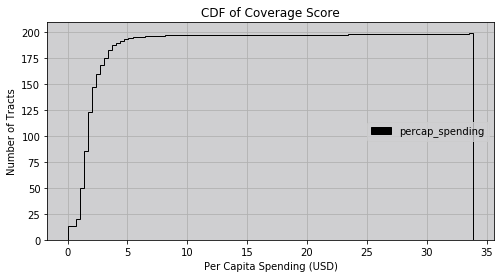

In [13]:
coverage.plot_cdf(filename = './data/coverage score/coverage_cdf_plot.png',
                  plot_type = "percap",
                  title = 'CDF of Coverage Score',
                  xlabel = 'Per Capita Spending (USD)',
                  ylabel = 'Number of Tracts')



The in-built charts are not designed for presentation purposes but you can save the results and graph them in another program. Here is an example:

<img src="figures/cdf_coverage.png" width="550" title="Optional title"  align="center">

### Choropleth Mapping

INFO:spatial_access.BaseModel:Figure was saved to: /Users/whlu/spatial_access/data/coverage score/coverage_choropleth.png


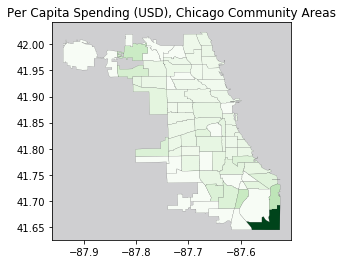

In [15]:
coverage.plot_choropleth(column = "percap_spending",
                         shapefile='./data/chicago_boundaries/chi_comm_boundaries.shp',
                         title = 'Per Capita Spending (USD), Chicago Community Areas',
                         include_destinations = False,
                         filename = './data/coverage score/coverage_choropleth.png')